In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')
from xgboost import XGBClassifier

In [2]:
DATASET_DIRECTORY = '/kaggle/input/unb-cic-iot-dataset/wataiData/csv/CICIoT2023/'

In [3]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
training_sets = df_sets[:int(len(df_sets)*.67)]
test_sets = df_sets[int(len(df_sets)*.67):]

In [4]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

In [5]:
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [6]:
ML_models = [ 
        LogisticRegression(),
        RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_leaf=5, class_weight='balanced', random_state=42),
        XGBClassifier(n_estimators=50, max_depth=5, reg_alpha=1, reg_lambda=1, subsample=0.8, random_state=42)
        ]

ML_names = [
        "Logistic Regression",
        "Random Forest",
        "XG BOOST"
]
correlation_matrices=[]
for train_set in tqdm(training_sets):
        d = pd.read_csv(DATASET_DIRECTORY + train_set)
        d[X_columns] = scaler.fit_transform(d[X_columns])
        new_y = [dict_7classes[k] for k in d[y_column]]
        d[y_column] = new_y
        from sklearn.preprocessing import LabelEncoder
        label_encoder = LabelEncoder()
        d[y_column] = label_encoder.fit_transform(d[y_column].values)
        X_train = d[X_columns].values
        y_train = d[y_column].values
        for model in ML_models:
            model.fit(X_train, y_train)
            correlation_matrices.append(d[X_columns].corrwith(d[y_column]))
        del d

100%|██████████| 113/113 [1:53:45<00:00, 60.40s/it]


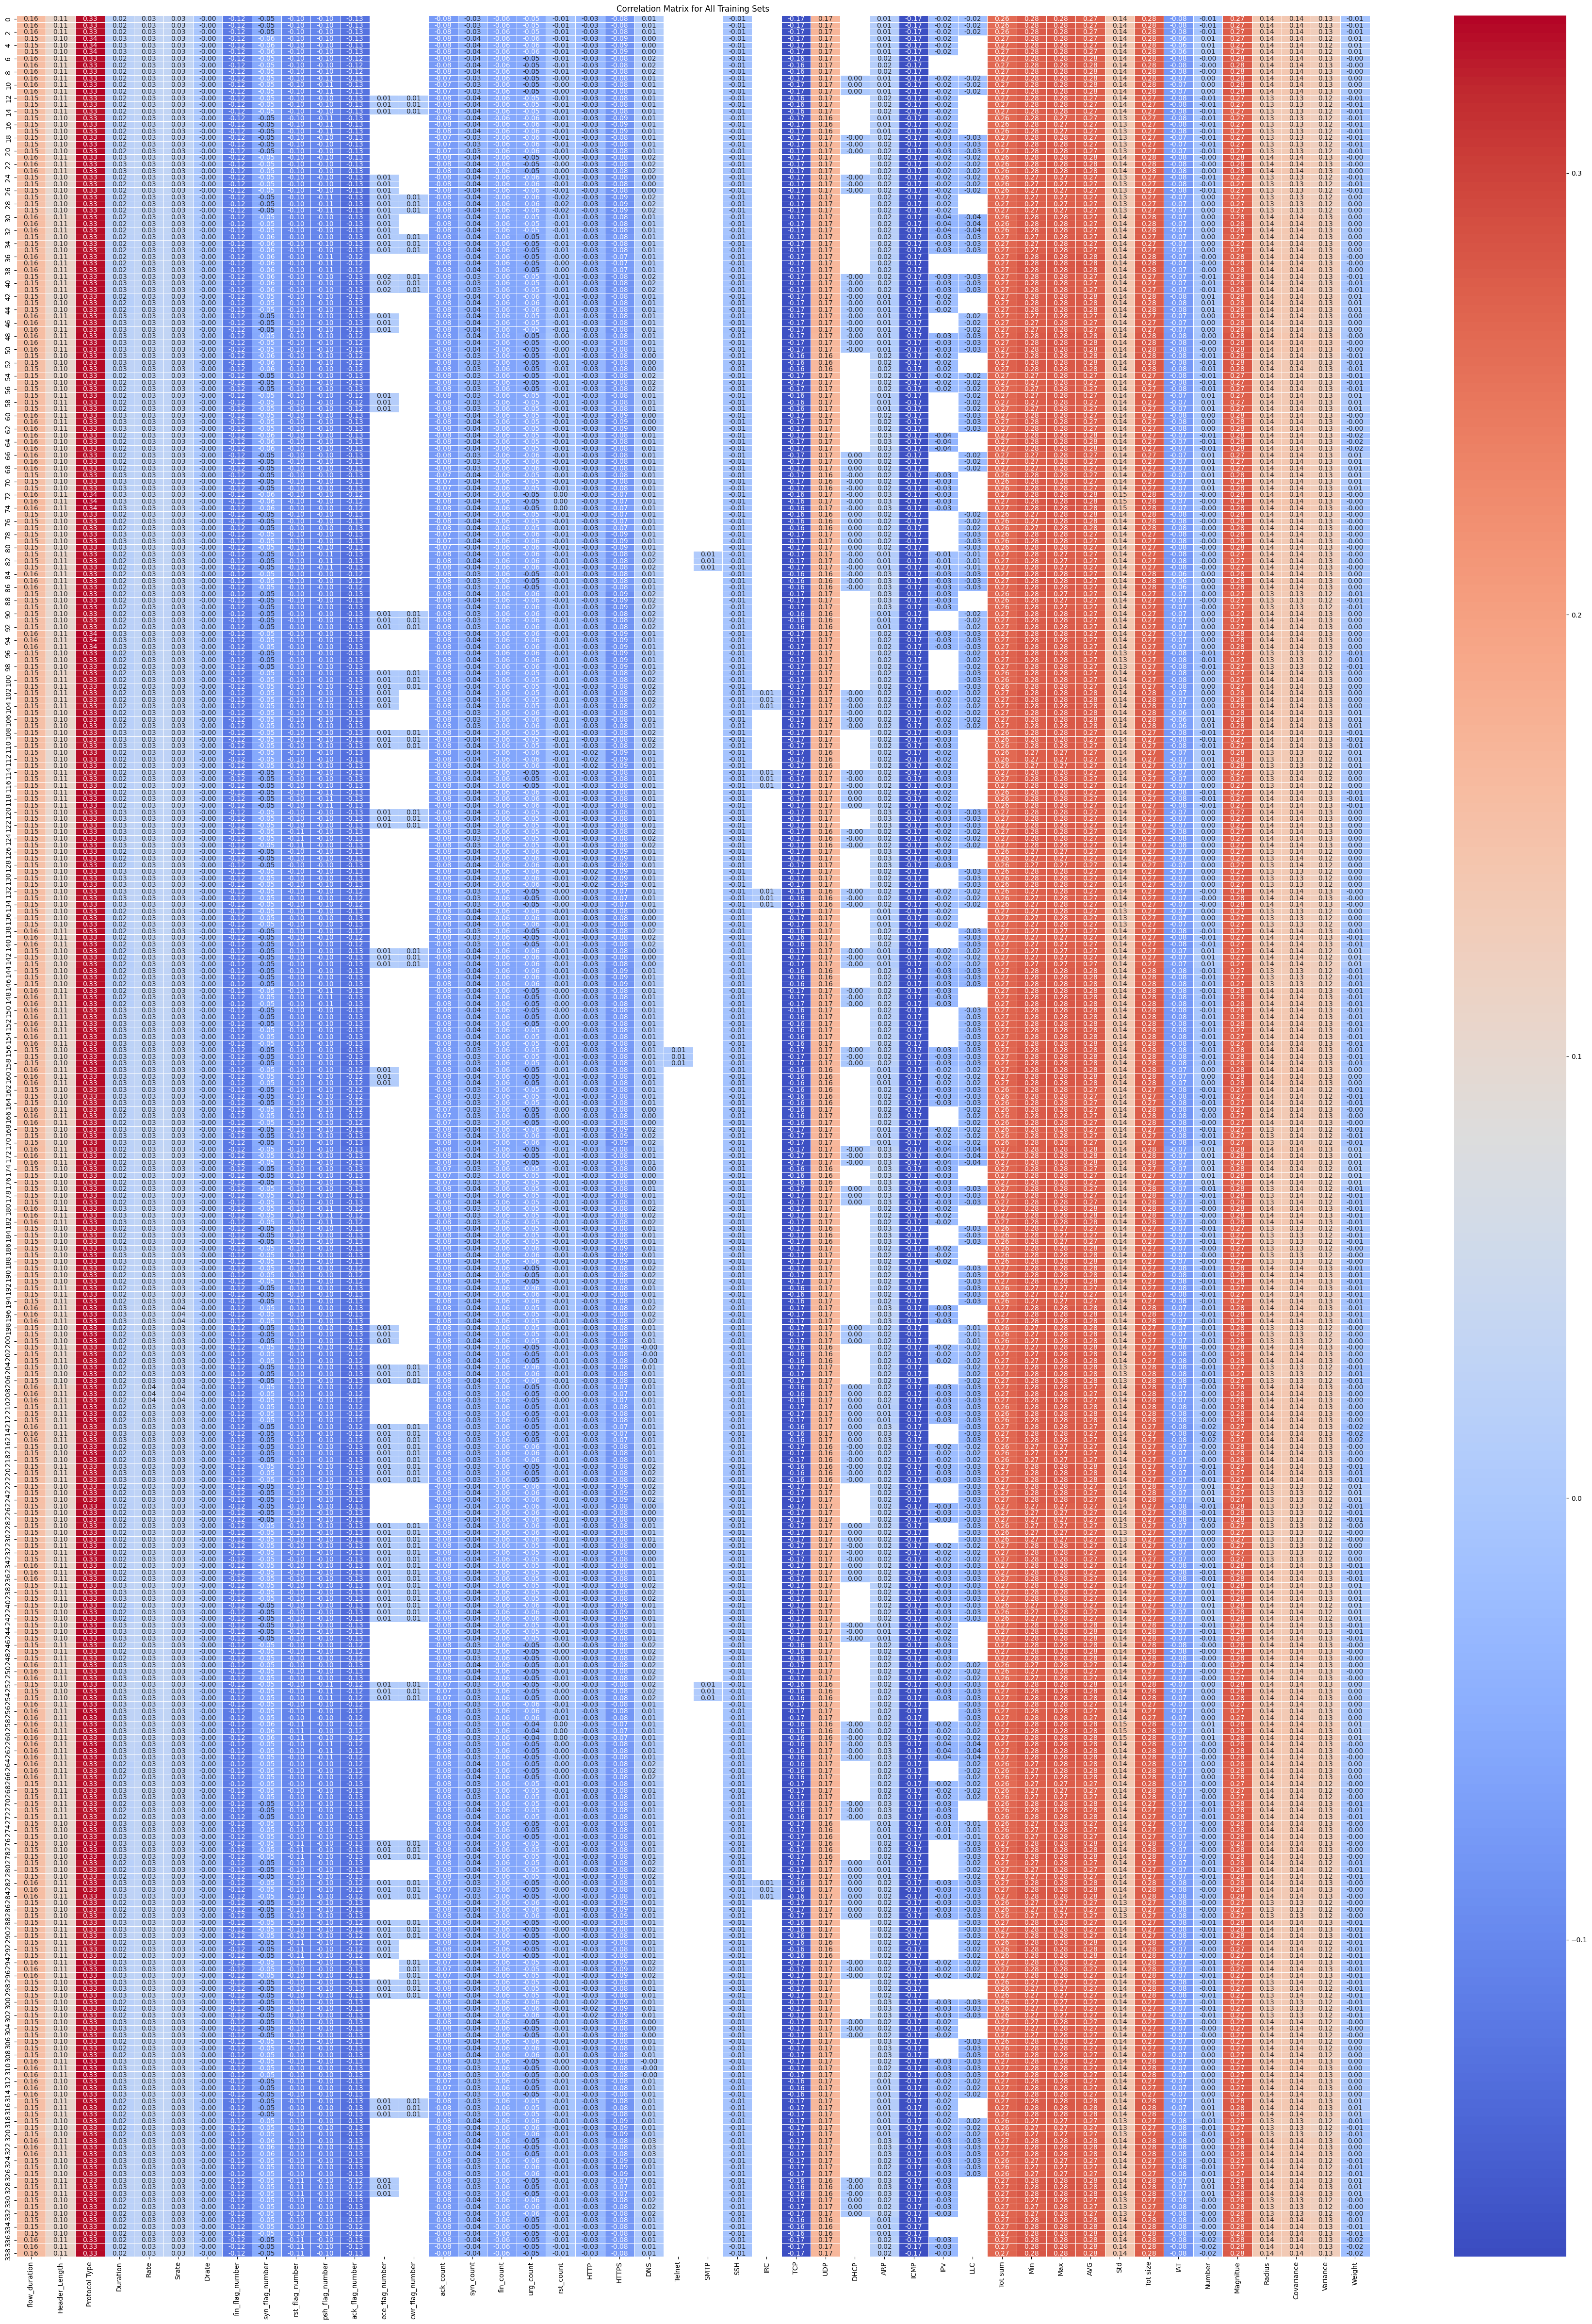

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(45,60))
sns.heatmap(correlation_matrices, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,
            xticklabels=X_columns)
plt.title("Correlation Matrix for All Training Sets")
plt.show()

In [8]:
for i in range(len(ML_models)):
    model = ML_models[i]
    import pickle
    with open('/kaggle/working/'+ML_names[i]+'_8classes.pkl', 'wb') as f:
        pickle.dump(model, f)

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
y_test = []
y_pred_proba=[]
preds = {i:[] for i in range(len(ML_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.fit_transform(d_test[X_columns])
    new_y = [dict_7classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y

    y_test += list(d_test[y_column].values)
    
    
    for i in range(len(ML_models)):
        model = ML_models[i]
        y_pred = list(model.predict(d_test[X_columns]))
        y_pred_proba += list(model.predict_proba(d_test[X_columns])[::,1])
        preds[i] = preds[i] + y_pred
        del y_pred
    del d_test

100%|██████████| 56/56 [10:40<00:00, 11.43s/it]


In [10]:
original_labels=["DDoS","DoS","Mirai","Recon","Spoofing","Benign","Web","BruteForce"]


Confusion Matrix for Logistic Regression:



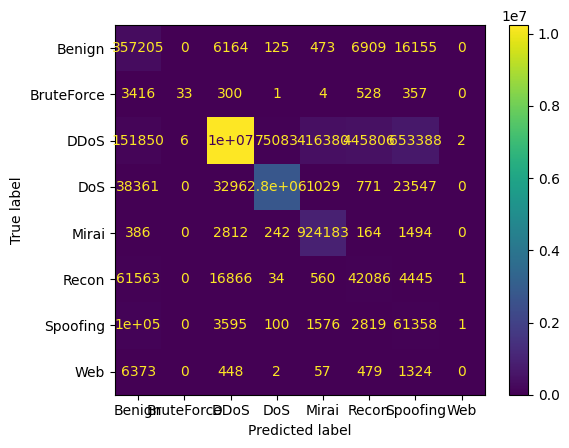

transfered
Logistic Regression
              precision    recall  f1-score   support

      Benign       0.50      0.92      0.64    387031
  BruteForce       0.85      0.01      0.01      4639
        DDoS       1.00      0.85      0.92  11981259
         DoS       0.97      0.98      0.98   2851474
       Mirai       0.69      0.99      0.81    929281
       Recon       0.08      0.34      0.13    125555
    Spoofing       0.08      0.36      0.13    171337
         Web       0.00      0.00      0.00      8683

    accuracy                           0.88  16459259
   macro avg       0.52      0.56      0.45  16459259
weighted avg       0.95      0.88      0.90  16459259

accuracy_score:  0.8753783508722962
recall_score:  0.5205162678616804
precision_score:  0.5561177470427949
f1_score:  0.4541472555170294

Confusion Matrix for Random Forest:



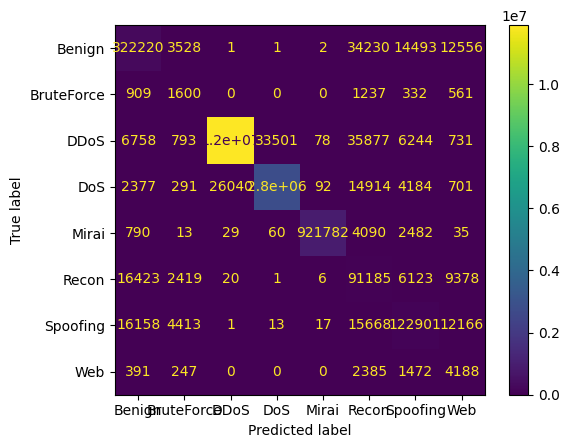

transfered
Random Forest
              precision    recall  f1-score   support

      Benign       0.88      0.83      0.86    387031
  BruteForce       0.12      0.34      0.18      4639
        DDoS       1.00      0.99      1.00  11981259
         DoS       0.99      0.98      0.99   2851474
       Mirai       1.00      0.99      1.00    929281
       Recon       0.46      0.73      0.56    125555
    Spoofing       0.78      0.72      0.75    171337
         Web       0.10      0.48      0.17      8683

    accuracy                           0.98  16459259
   macro avg       0.67      0.76      0.69  16459259
weighted avg       0.99      0.98      0.98  16459259

accuracy_score:  0.982062922759767
recall_score:  0.665477053611591
precision_score:  0.7589006650481671
f1_score:  0.6860710018129402

Confusion Matrix for XG BOOST:



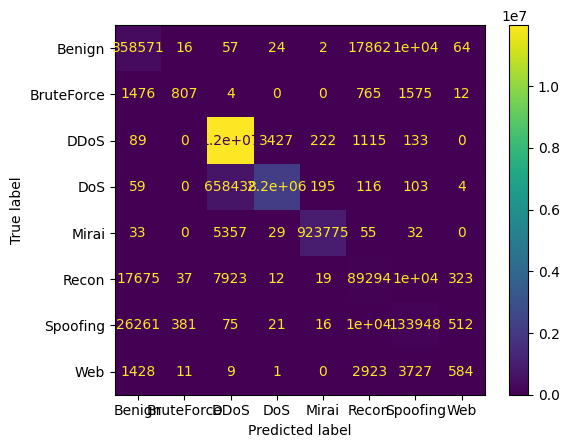

transfered
XG BOOST
              precision    recall  f1-score   support

      Benign       0.88      0.93      0.90    387031
  BruteForce       0.64      0.17      0.27      4639
        DDoS       0.95      1.00      0.97  11981259
         DoS       1.00      0.77      0.87   2851474
       Mirai       1.00      0.99      1.00    929281
       Recon       0.73      0.71      0.72    125555
    Spoofing       0.84      0.78      0.81    171337
         Web       0.39      0.07      0.11      8683

    accuracy                           0.95  16459259
   macro avg       0.80      0.68      0.71  16459259
weighted avg       0.95      0.95      0.95  16459259

accuracy_score:  0.952400773327645
recall_score:  0.80367772775367
precision_score:  0.6779048677353534
f1_score:  0.7075222357462108


In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
for k,v in preds.items():
    y_pred = v
    label_encoder.fit(original_labels)
    y_pred = label_encoder.inverse_transform(y_pred)
    print(f"\nConfusion Matrix for {ML_names[k]}:\n")
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print("transfered")    
    print(f"{ML_names[k]}")
    print(classification_report(y_test,y_pred))
    print('accuracy_score: ', accuracy_score(y_pred, y_test))
    print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
    print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
    print('f1_score: ', f1_score(y_pred, y_test, average='macro'))